In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import random
import math
import time

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../code/')
import util
import ssm


### Set the path and specification that you want to predict

In [2]:
data_path = '../data/transformer_data'
spec = 'airworthy' #'hover'#'interference'#'dist' #'mass' #'airworthy'
max_mass = 35. #(kg)

### Download the dataset and build the data loaders

In [3]:
torch.manual_seed(0)
np.random.seed(0)
batch_size = 2 # 512
batch_size_val = 2 # 512
frac_train = 0.4
frac_val = 0.4

dataloader_tr, dataloader_val, dataloader_test, scale_1, scale_2 = ssm.prepare_sequence_data(data_path, spec, batch_size = batch_size ,batch_size_val = batch_size_val, frac_train = frac_train, frac_val = frac_val)

In [4]:
print(f'Training Data:   {dataloader_tr.dataset.y_train.shape[0]}')
print(f'Validation Data: {dataloader_val.dataset.y_train.shape[0]}')
print(f'Test Data:       {dataloader_test.dataset.y_train.shape[0]}')

Training Data:   6
Validation Data: 6
Test Data:       3


### Set up model from the seq_to_spec_model.py

In [6]:
from ssm import TransformerModel, LSTM

mode = 'transformer' #'lstm'

torch.manual_seed(0)
np.random.seed(0)

emsize = 200  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 8  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
D_out = 1
D = dataloader_tr.dataset.x_train.shape[-1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(3)

if mode == 'transformer':
    model = TransformerModel( emsize, nhead, d_hid, nlayers, dropout, D, D_out).to(device)
elif mode == 'lstm':
    model = LSTM(D, emsize, d_hid).to(device)

### Set up the training routine

In [7]:
import copy
import time

if spec == 'airworthy' or spec == 'interference':
    criterion = nn.BCELoss() # nn.CrossEntropyLoss()
    sig = nn.Sigmoid()
if spec == 'mass' or spec == 'dist' or spec == 'hover':
    criterion = nn.MSELoss()
    
lr = .1  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = 0 #bptt
    for batch, train_data in enumerate(dataloader_tr):
        data, targets, mask = train_data
        
        if mode == 'transformer':
            output = model(data.to(device), mask.to(device))
        elif mode == 'lstm':
            output = model(data.to(device), int(data.shape[1]))
        
        if spec == 'airworthy' or spec == 'interference':
            loss = criterion(sig(output), targets.view(-1,D_out).to(device))
        if spec == 'mass' or spec == 'hover':
            loss = criterion(output, targets.view(-1,D_out).to(device))
        if spec == 'dist':
            loss = criterion(torch.selu(output), targets.view(-1,D_out).to(device))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss/num_batches

def evaluate(model: nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    num_batches = 0
    with torch.no_grad():
        for batch, val_data in enumerate(dataloader_val):
            data, targets, mask = val_data
            if mode == 'transformer':
                output = model(data.to(device), mask.to(device))
            elif mode == 'lstm':
                output = model(data.to(device), int(data.shape[1]))
            if spec == 'airworthy' or spec == 'interference':
                loss = criterion(sig(output), targets.view(-1,D_out).to(device))
            if spec == 'mass' or spec == 'hover':
                loss = criterion(output, targets.view(-1,D_out).to(device))
            if spec == 'dist':
                loss = criterion(torch.selu(output), targets.view(-1,D_out).to(device))
            num_batches += 1
            total_loss += loss.item()
    return total_loss/num_batches

### Train the model and save the best according to the validation data

In [8]:
best_loss = float('inf')
epochs = 2 #300
best_model = None

loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    loss = train(model)
    val_loss = evaluate(model)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'loss {loss:5.4f} | '
          f'val loss {val_loss:5.4f}' )
    print('-' * 89)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
    loss_list.append(loss)
    val_loss_list.append(val_loss)
#     scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  5.96s | loss 0.6506 | val loss 0.5380
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  4.76s | loss 0.5587 | val loss 0.6321
-----------------------------------------------------------------------------------------


### Plot the training and validation loss

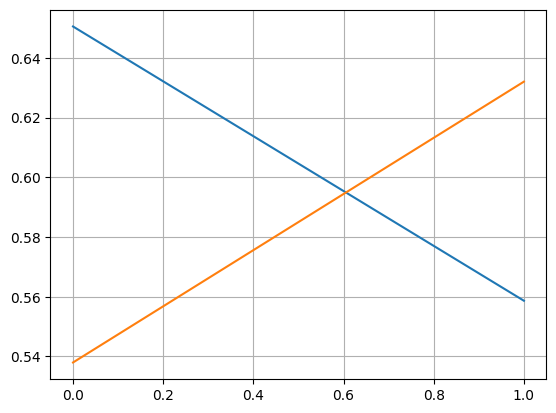

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_list)
plt.plot(val_loss_list)
plt.grid()
plt.show()

In [10]:
output = torch.zeros_like(dataloader_test.dataset.y_train)
i = 0
for x,y,m in dataloader_test:
    with torch.no_grad():
        print(x.shape)
        print(y.shape)
        best_model.eval().to(device)
        if mode == 'transformer':
            output[i:i + y.shape[0]] = best_model(x.to(device), m.to(device)).cpu().flatten()
        elif mode == 'lstm':
            output[i:i + y.shape[0]] = best_model(x.to(device), int(x.shape[1])).cpu().flatten()
        i += y.shape[0]

torch.Size([3, 69, 653])
torch.Size([3])


In [11]:
if spec == 'mass' or spec == 'hover':
    criterion = nn.MSELoss()
    o_un = output * scale_2 + scale_1
    y_t = dataloader_test.dataset.y_train * scale_2 + scale_1
    print(criterion(o_un, y_t))
if spec == 'dist':
    criterion = nn.MSELoss()
    o_un = torch.selu(output) * (scale_2 + scale_1) - scale_1
    y_t = dataloader_test.dataset.y_train * (scale_2 + scale_1) - scale_1
    print(criterion(o_un / 1000., y_t /1000.))

In [12]:
if spec == 'airworthy' or spec == 'interference':

    from sklearn.metrics import confusion_matrix
    threshold = 0.5
    y_pred = (torch.sigmoid(output).flatten().detach().cpu() > threshold).float().numpy()

    conf_matrix = confusion_matrix(y_true=dataloader_test.dataset.y_train.numpy(), y_pred=y_pred)

    util.plot_confusion_matrix(cm           = conf_matrix,
                          normalize    = False,
                          target_names = ['0', '1'],
    #                       title        = "Confusion Matrix, Normalized: Thresh {}".format(threshold))
                          title        = "Confusion Matrix: Validation Data ")

ModuleNotFoundError: No module named 'sklearn'